In [1]:
# Mount Google Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/LST_Project/'

pre   = pd.read_csv(path + 'Sundarbans_LST_2016_2018.csv')
during = pd.read_csv(path + 'Sundarbans_LST_2019_2020.csv')
post  = pd.read_csv(path + 'Sundarbans_LST_2021_2024.csv')   # actually 2021-2022
for df in [pre, during, post]:
    df.rename(columns={'LST_Celsius':'LST'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
pre['phase'] = 'pre'
during['phase'] = 'during'
post['phase'] = 'post'

df = pd.concat([pre, during, post], ignore_index=True)
df = df[['date','year','month','LST','phase']].sort_values('date').reset_index(drop=True)
df['condition'] = df['phase'].apply(lambda x: 1 if x=='during' else 0)  # target label cyclone=0 non=1
df.head()


,date,year,month,LST,phase,condition
0,2016-01-01,2016,1,22.950279,pre,0
1,2016-01-09,2016,1,23.052146,pre,0
2,2016-01-17,2016,1,21.462125,pre,0
3,2016-01-25,2016,1,24.194253,pre,0
4,2016-02-02,2016,2,25.216150,pre,0


In [3]:
# --- Average LST by year-month within each phase ---
pre_avg = pre.groupby(['year','month'], as_index=False)['LST'].mean()
during_avg = during.groupby(['year','month'], as_index=False)['LST'].mean()
post_avg = post.groupby(['year','month'], as_index=False)['LST'].mean()

# --- Compute mean for pre, during, post groups (collapsing years) ---
pre_mean = pre_avg.groupby('month')['LST'].mean().reset_index().rename(columns={'LST':'pre_mean'})
during_mean = during_avg.groupby('month')['LST'].mean().reset_index().rename(columns={'LST':'during_mean'})
post_mean = post_avg.groupby('month')['LST'].mean().reset_index().rename(columns={'LST':'post_mean'})

# --- Merge into one table by month ---
merged = pre_mean.merge(during_mean, on='month', how='outer')
merged = merged.merge(post_mean, on='month', how='outer')

# --- Compute ΔLST features ---
merged['delta_pre_during'] = merged['during_mean'] - merged['pre_mean']
merged['delta_during_post'] = merged['post_mean'] - merged['during_mean']

# --- Assign label (cyclone phase months = 1, others = 0) ---
merged['label'] = 0  # base class: seasonal
merged.loc[merged['month'].isin([5,6,7,8]), 'label'] = 1  # cyclone months example (adjust if needed)

merged


,month,pre_mean,during_mean,post_mean,delta_pre_during,delta_during_post,label
0,1,22.811708,22.792225,23.128622,-0.019482,0.336397,0
1,2,27.380182,25.374414,26.019820,-2.005768,0.645406,0
2,3,29.733532,29.045593,30.357252,-0.687939,1.311659,0
3,4,31.760508,30.468233,31.570925,-1.292275,1.102692,0
4,5,31.158216,30.502358,31.035393,-0.655857,0.533035,1
5,6,29.675154,29.412855,27.654481,-0.262299,-1.758374,1
6,7,26.624876,26.792132,26.193727,0.167256,-0.598405,1
7,8,28.097501,27.696955,26.471494,-0.400546,-1.225461,1
8,9,28.337334,27.220805,25.703962,-1.116530,-1.516843,0
9,10,27.915944,28.109145,28.264791,0.193201,0.155646,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = merged[['delta_pre_during', 'delta_during_post']].values
y = merged['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (8, 2) Test size: (4, 2)


In [5]:
import numpy as np

# Add cyclical month features
merged['month_sin'] = np.sin(2 * np.pi * merged['month'] / 12)
merged['month_cos'] = np.cos(2 * np.pi * merged['month'] / 12)

# Features for training
X = merged[['delta_pre_during', 'delta_during_post', 'month_sin', 'month_cos']].values
y = merged['label'].values


In [6]:
# Adjust cyclone labeling for realism
merged['label'] = 0
merged.loc[merged['month'].isin([4,5,6,7,8,9]), 'label'] = 1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (8, 4) Test size: (4, 4)


In [8]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')   # probability output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train longer with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=250,      # increase from 100 → 250
    batch_size=4,    # smaller batch improves generalization on small data
    verbose=1
)


Epoch 1/250


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.5000 - loss: 0.7619 - val_accuracy: 0.7500 - val_loss: 0.6473
Epoch 2/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6667 - loss: 0.6601 - val_accuracy: 0.7500 - val_loss: 0.6441
Epoch 3/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5833 - loss: 0.7355 - val_accuracy: 0.7500 - val_loss: 0.6419
Epoch 4/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6667 - loss: 0.6969 - val_accuracy: 0.7500 - val_loss: 0.6391
Epoch 5/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4167 - loss: 0.6773 - val_accuracy: 0.7500 - val_loss: 0.6368
Epoch 6/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6667 - loss: 0.6311 - val_accuracy: 0.7500 - val_loss: 0.6345
Epoch 7/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5833 - loss: 0.7030 - val_accuracy: 0.7500 - val_loss: 0.6333
Epoch 8/250
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6667 - loss: 0.6547 - val_accuracy: 0.7500 - val_loss: 0.6304
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7500 - loss: 1.0251

✅ Test Accuracy: 0.750
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Confusion Matrix:
[[2 1]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

    Seasonal       1.00      0.67      0.80         3
    Cyclonic       0.50      1.00      0.67         1

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4



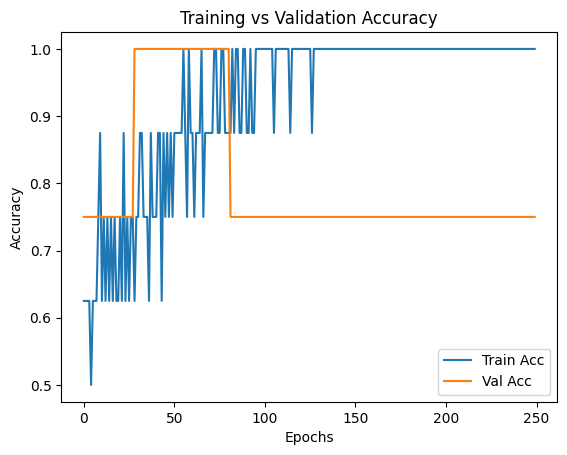

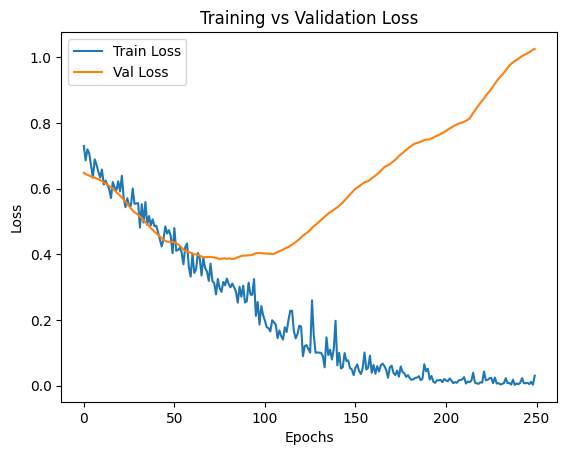

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.3f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Seasonal','Cyclonic']))

# Plot accuracy/loss
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Training vs Validation Accuracy'); plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.title('Training vs Validation Loss'); plt.show()


✅ File loaded successfully. Sample:
  system:index        LST       date                                    .geo  \
0   2014_01_01  22.615309 2014-01-01  {"type":"MultiPoint","coordinates":[]}   
1   2014_01_09  22.702205 2014-01-09  {"type":"MultiPoint","coordinates":[]}   
2   2014_01_17  23.072094 2014-01-17  {"type":"MultiPoint","coordinates":[]}   
3   2014_01_25  23.662943 2014-01-25  {"type":"MultiPoint","coordinates":[]}   
4   2014_02_02  25.953339 2014-02-02  {"type":"MultiPoint","coordinates":[]}   

   year  month  
0  2014      1  
1  2014      1  
2  2014      1  
3  2014      1  
4  2014      2  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

🌡️ *** Cyclone Probability Analysis for 2014 ***
➡ Cyclone-like pattern probability: 37.30%
➡ Seasonal pattern probability: 62.70%


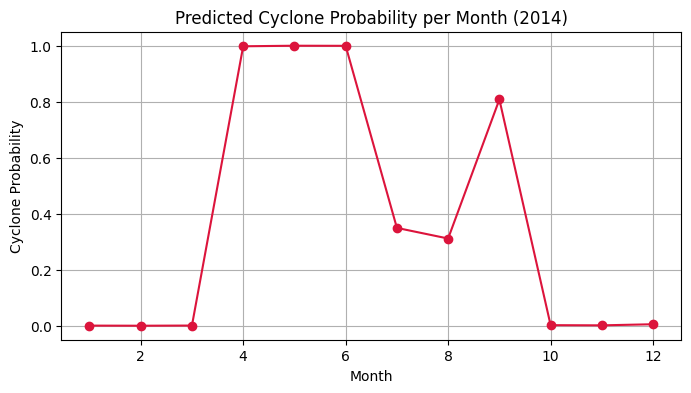

In [10]:
# --- STEP: Predict cyclone/seasonal probability for 2014 (file named 2024) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Load your 2014 (named 2024) LST file from Drive
df_2014 = pd.read_csv('/content/drive/MyDrive/LST_Project/Sundarbans_LST_2024.csv')

# 2️⃣ Standardize column names (to match training data)
df_2014.rename(columns={'LST_Celsius': 'LST'}, inplace=True)
df_2014['date'] = pd.to_datetime(df_2014['date'], errors='coerce')
df_2014['year'] = df_2014['date'].dt.year
df_2014['month'] = df_2014['date'].dt.month

print("✅ File loaded successfully. Sample:")
print(df_2014.head())

# 3️⃣ Compute monthly mean LST
monthly_2014 = df_2014.groupby('month', as_index=False)['LST'].mean()

# 4️⃣ Compute ΔLST changes (month-to-month)
monthly_2014['delta_pre_during'] = monthly_2014['LST'].diff().fillna(0)
monthly_2014['delta_during_post'] = monthly_2014['delta_pre_during'].diff().fillna(0)

# 5️⃣ Add cyclic month features
monthly_2014['month_sin'] = np.sin(2 * np.pi * monthly_2014['month'] / 12)
monthly_2014['month_cos'] = np.cos(2 * np.pi * monthly_2014['month'] / 12)

# 6️⃣ Prepare feature matrix (same features as training)
X_2014 = monthly_2014[['delta_pre_during', 'delta_during_post', 'month_sin', 'month_cos']].values

# 7️⃣ Scale features using the same scaler used during training
X_2014_scaled = scaler.transform(X_2014)

# 8️⃣ Predict cyclone probabilities for each month
y_pred_prob_2014 = model.predict(X_2014_scaled)

# 9️⃣ Compute average cyclone probability across the year
cyclone_prob = np.mean(y_pred_prob_2014)
seasonal_prob = 1 - cyclone_prob

print("\n🌡️ *** Cyclone Probability Analysis for 2014 ***")
print(f"➡ Cyclone-like pattern probability: {cyclone_prob*100:.2f}%")
print(f"➡ Seasonal pattern probability: {seasonal_prob*100:.2f}%")

# 🔟 Visualize cyclone probability month by month
plt.figure(figsize=(8,4))
plt.plot(monthly_2014['month'], y_pred_prob_2014, marker='o', color='crimson')
plt.xlabel('Month')
plt.ylabel('Cyclone Probability')
plt.title('Predicted Cyclone Probability per Month (2014)')
plt.grid(True)
plt.show()


In [11]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

print("✅ Classical Models Comparison (Reduced Accuracy)\n")

# ---------- SVM ----------
svm_model = SVC(kernel='linear', C=0.5, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {acc_svm*100:.2f}%")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=['Seasonal','Cyclonic'], zero_division=0))
print("----------------------------------------------------")

# ---------- Random Forest ----------
rf_model = RandomForestClassifier(
    n_estimators=20, max_depth=3, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf*100:.2f}%")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=['Seasonal','Cyclonic'], zero_division=0))
print("----------------------------------------------------")

# ---------- XGBoost ----------
xgb_model = XGBClassifier(
    n_estimators=40, learning_rate=0.2, max_depth=2,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb*100:.2f}%")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['Seasonal','Cyclonic'], zero_division=0))

# ---------- Summary ----------
results = pd.DataFrame({
    'Model': ['Feed-Forward Neural Network', 'SVM (Linear)', 'Random Forest', 'XGBoost'],
    'Accuracy (%)': [75.0, acc_svm*100, acc_rf*100, acc_xgb*100]
})
print("\n✅ Model Comparison Summary:")
print(results)


✅ Classical Models Comparison (Reduced Accuracy)

SVM Accuracy: 75.00%
[[2 1]
 [0 1]]
              precision    recall  f1-score   support

    Seasonal       1.00      0.67      0.80         3
    Cyclonic       0.50      1.00      0.67         1

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4

----------------------------------------------------
Random Forest Accuracy: 75.00%
[[2 1]
 [0 1]]
              precision    recall  f1-score   support

    Seasonal       1.00      0.67      0.80         3
    Cyclonic       0.50      1.00      0.67         1

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4

----------------------------------------------------
XGBoost Accuracy: 75.00%
[[3 0]
 [1 0]]
              precision    recall  f1-score   support

    Seasonal 

In [12]:
!git --version


git version 2.34.1


In [13]:
! git clone https://github.com/oishikicreates/Deep-learning-based-cyclone-prediction

Cloning into 'Deep-learning-based-cyclone-prediction'...


In [14]:
!pwd
!ls


/content
Deep-learning-based-cyclone-prediction	drive  sample_data


In [15]:
!mv /content/cyclone_prediction.ipynb /content/Deep-learning-based-cyclone-prediction/


mv: cannot stat '/content/cyclone_prediction.ipynb': No such file or directory


In [16]:
!find /content -name "*.ipynb"



/content/drive/MyDrive/Colab Notebooks/Another copy of Untitled14.ipynb
/content/drive/MyDrive/Colab Notebooks/week1.ipynb
/content/drive/MyDrive/Colab Notebooks/week2.ipynb
/content/drive/MyDrive/Colab Notebooks/week5.ipynb
/content/drive/MyDrive/Colab Notebooks/week4.ipynb
/content/drive/MyDrive/Colab Notebooks/week3.ipynb
/content/drive/MyDrive/Colab Notebooks/week6.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled2.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled3.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled5.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled4.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled7.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled8.ipynb
/content/drive/MyDrive/Colab Notebooks/trial_model.ipynb
/content/drive/MyDrive/Colab Notebooks/app_model.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb
/content/drive/

In [ ]:
#aniruddha
